<a href="https://colab.research.google.com/github/javierbaldrich/5511/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Disaster Tweets Kaggle Mini-Project

The goal of this project is to use our knowledge of recurrent neural networks to train a model in the context of a classification problem. In this case, the classification is relative to a corpus of tweets that can be related to disaster or not.

The dataset we will use was posted in Kaggle ([in this specific page](https://www.kaggle.com/c/nlp-getting-started/overview)).

Apart from the tweet text (and, in the case of the training dataset, the response), both the test and the training datasets contain two additional columns that might have explainatory value. However for the purposes of focusing on the NLP task, I will ignore them in my training.

The training records are 7613 and the test records are 3263.


--------------------------------------------
I will start by importing all the libraries I will be using:

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import ngrams, word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, CuDNNLSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.optimizers import Adam
!pip install keras-tuner --upgrade --quiet
import keras_tuner as kt
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now that we have all our tools, we import the files (which I have saved in my Google Drive).

Next, we proceed to take an initial look at the data.

In [2]:
# Pull the datasets into Pandas dataframse
train_df = pd.read_csv('/content/drive/MyDrive/5511/disaster_nlp/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/5511/disaster_nlp/test.csv')

# Print the first few records of both datasets
print('Training dataset') 
print(train_df.head().to_string())
print('Test dataset') 
print(test_df.head().to_string())

# Remove all predictive fields other than 'text' from taining dataset
train_df = train_df[['id', 'text', 'target']]
test_df = test_df[['id', 'text']]


Training dataset
   id keyword location                                                                                                                                   text  target
0   1     NaN      NaN                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1   4     NaN      NaN                                                                                                 Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
3   6     NaN      NaN                                                                      13,000 people receive #wildfires evacuation orders in California        1
4   7     NaN      NaN                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a sch

We can see that in the training dataset we have 43% of tweets with a 'disaster' label

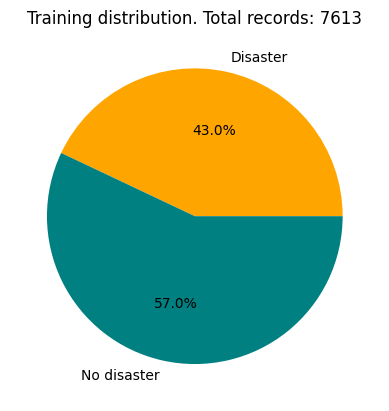

In [3]:
# Training distribution
labels = 'Disaster', 'No disaster'
colors = ['orange', 'teal']
sizes = [train_df[train_df['target']==1].shape[0], train_df[train_df['target']==0].shape[0]]
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title(f'Training distribution. Total records: {train_df.shape[0]}')
plt.show()


Now we will actually print a few more records from the training dataset to see how to best clean the text they conatin.

In [4]:
# Print the first few records of both datasets
print('Training dataset') 
print(train_df.head(25).to_string())


Training dataset
    id                                                                                                                                   text  target
0    1                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1    4                                                                                                 Forest fire near La Ronge Sask. Canada       1
2    5  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
3    6                                                                      13,000 people receive #wildfires evacuation orders in California        1
4    7                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school        1
5    8                         #RockyFire Update => California Hwy. 20 closed in bo

We will do this by removing whitespaces (except for spaces), making everything lowercase, removing URLs, emojis, punctuation and stop-words (or common words).

In [5]:
# Function to clean the text within tweets
def clean_text(text):

    # Remove all whitespace except spaces
    text = re.sub(r'[^\S\n\r]', ' ', text)

    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile('['
                               u'\U0001F600-\U0001F64F'  # emoticons
                               u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                               u'\U0001F680-\U0001F6FF'  # transport & map symbols
                               u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                               u'\U00002500-\U00002BEF'  # chinese char
                               u'\U00002702-\U000027B0'
                               u'\U00002702-\U000027B0'
                               u'\U000024C2-\U0001F251'
                               u'\U0001f926-\U0001f937'
                               u'\U00010000-\U0010ffff'
                               u'\u2640-\u2642'
                               u'\u2600-\u2B55'
                               u'\u200d'
                               u'\u23cf'
                               u'\u23e9'
                               u'\u231a'
                               u'\ufe0f'  # dingbats
                               u'\u3030'
                               ']+', re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove everything but letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove stop-words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply to both datasets
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)


# Training dataset after cleaning
print('Training dataset') 
print(train_df.head(25).to_string())


Training dataset
    id                                                                                         text  target
0    1                                                 deeds reason earthquake may allah forgive us       1
1    4                                                        forest fire near la ronge sask canada       1
2    5     residents asked shelter place notified officers evacuation shelter place orders expected       1
3    6                                        people receive wildfires evacuation orders california       1
4    7                                      got sent photo ruby alaska smoke wildfires pours school       1
5    8      rockyfire update california hwy closed directions due lake county fire cafire wildfires       1
6   10       flood disaster heavy rain causes flash flooding streets manitou colorado springs areas       1
7   13                                                                   im top hill see fire woods       1
8   14     

We will now look into common words and bigrams in both disaster and non-disaster tweets.

We will start with disaster tweets and add two fields ('tokens' and 'bigrams') that contain that information for each record. The reason we want to look at bigrams as well is because, as we have seen in our RNN classes, words acquire enriched meaning with their content. Therefore, a word being accompanied by another word migth give us more informatino than both words alone. 

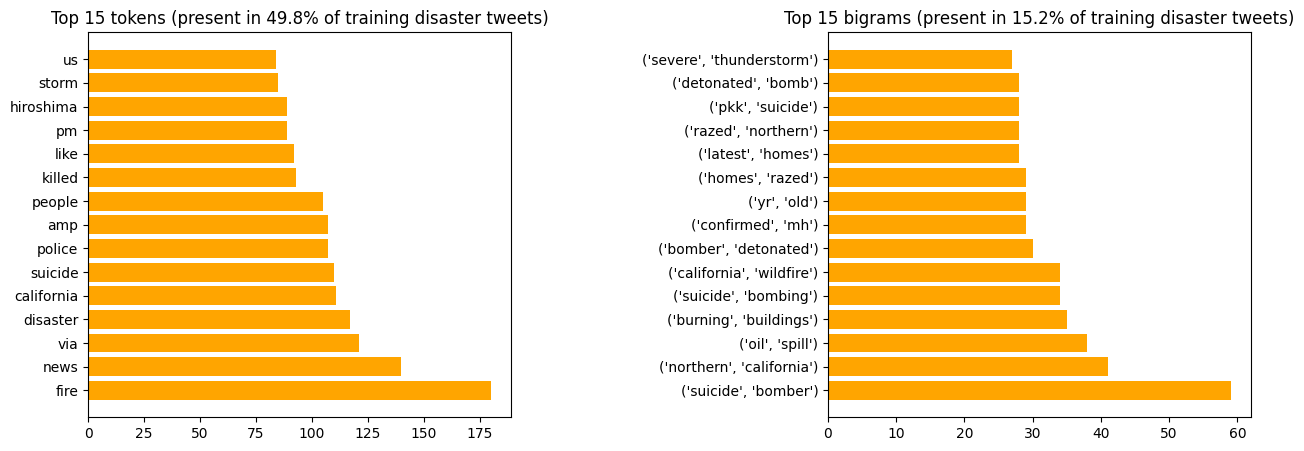

In [6]:
# Tokenize the tweets into words and bigrams
train_disaster_df = train_df[train_df['target']==1].copy() 
train_disaster_df['tokens'] = train_disaster_df['text'].apply(lambda x: word_tokenize(x))
train_disaster_df['bigrams'] = train_disaster_df['tokens'].apply(lambda x: [i for i in ngrams(x, 2)])

# Retrieve the top 15 most common tokens and bigrams
tokens_list = sum(train_disaster_df['tokens'].tolist(), [])
bigrams_list = sum(train_disaster_df['bigrams'].tolist(), [])
most_common_tokens = Counter(tokens_list).most_common(15)
tokens = [key for key, val in most_common_tokens]
tokens_cnt = [val for key, val in most_common_tokens]
most_common_bigrams = Counter(bigrams_list).most_common(15)
bigrams = [str(key) for key, val in most_common_bigrams]
bigrams_cnt = [val for key, val in most_common_bigrams]

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.barh(tokens, tokens_cnt, color='orange')
ax1.set_title(f'Top 15 tokens (present in {"{:.1%}".format(sum(tokens_cnt)/train_disaster_df.shape[0])} of training disaster tweets)')
ax2.barh(bigrams, bigrams_cnt, color='orange')
ax2.set_title(f'Top 15 bigrams (present in {"{:.1%}".format(sum(bigrams_cnt)/train_disaster_df.shape[0])} of training disaster tweets)')
plt.subplots_adjust(wspace=0.75)


Now we do the exact same procedure for non-disaster tweets

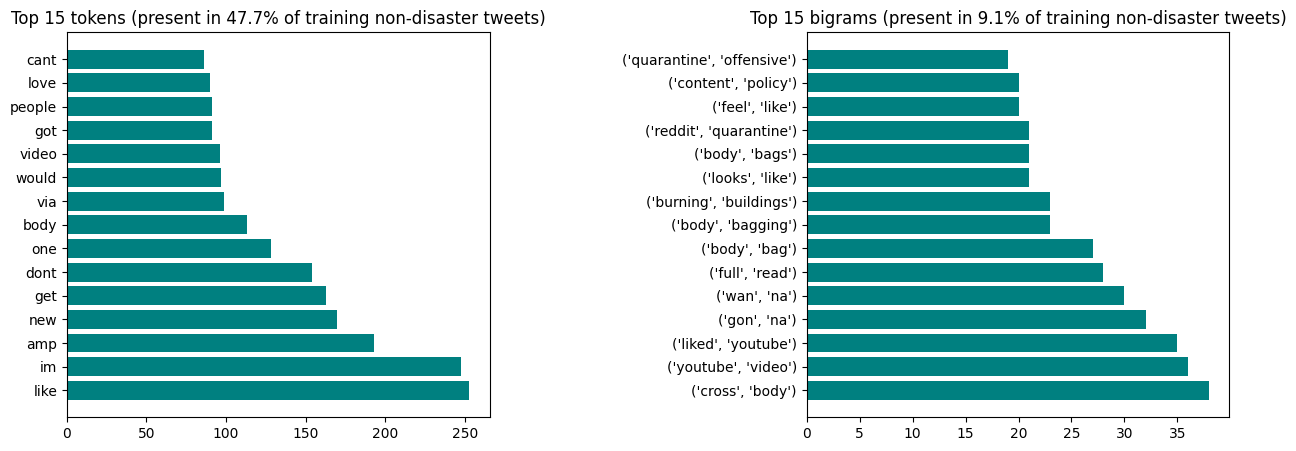

In [7]:
# Tokenize the tweets into words and bigrams
train_non_disaster_df = train_df[train_df['target']==0].copy() 
train_non_disaster_df['tokens'] = train_non_disaster_df['text'].apply(lambda x: word_tokenize(x))
train_non_disaster_df['bigrams'] = train_non_disaster_df['tokens'].apply(lambda x: [i for i in ngrams(x, 2)])

# Retrieve the top 15 most common tokens and bigrams
tokens_list = sum(train_non_disaster_df['tokens'].tolist(), [])
bigrams_list = sum(train_non_disaster_df['bigrams'].tolist(), [])
most_common_tokens = Counter(tokens_list).most_common(15)
tokens = [key for key, val in most_common_tokens]
tokens_cnt = [val for key, val in most_common_tokens]
most_common_bigrams = Counter(bigrams_list).most_common(15)
bigrams = [str(key) for key, val in most_common_bigrams]
bigrams_cnt = [val for key, val in most_common_bigrams]

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.barh(tokens, tokens_cnt, color='teal')
ax1.set_title(f'Top 15 tokens (present in {"{:.1%}".format(sum(tokens_cnt)/train_non_disaster_df.shape[0])} of training non-disaster tweets)')
ax2.barh(bigrams, bigrams_cnt, color='teal')
ax2.set_title(f'Top 15 bigrams (present in {"{:.1%}".format(sum(bigrams_cnt)/train_non_disaster_df.shape[0])} of training non-disaster tweets)')
plt.subplots_adjust(wspace=0.75)
plt.show()


We now create the padded sequences, whereby we:

1.   Label each token with a number using the tokenizer, just like using a dicionary where the keys are numbers and the values are words.
2.   Pad with zeros all sentences that are shorter (in words) than the longest sentence. This way we get a matrix of size (num_of_sentences, max_num_of_words).


In [8]:
# define the tokenizer
tokenizer = Tokenizer(num_words=2048, lower=True)
tokenizer.fit_on_texts(train_df['text'])

# convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# pad the sequences
max_sequence_length = max(len(sequence) for sequence in train_sequences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(train_padded_sequences.shape)
print(train_padded_sequences[:5])


(7613, 17)
[[ 707  150   55 1426   12    0    0    0    0    0    0    0    0    0
     0    0    0]
 [  96    4  129  528 1216    0    0    0    0    0    0    0    0    0
     0    0    0]
 [1551 1427 1927  545 1552  151 1927  545 1217  939    0    0    0    0
     0    0    0]
 [  10 1218  151 1217   24    0    0    0    0    0    0    0    0    0
     0    0    0]
 [  28 1049  223 1928  160 1218   93    0    0    0    0    0    0    0
     0    0    0]]


Now we can build our model. We will use Keras' hyperparameter tuner tool to iterate over possible models and test their accuracy against a validation split. Th

1.   Pass the padded sequence into an Embedding layer in our model, which will create vectors with 256 dimensions that encode the meaning of words.
2.   Pass the vector of meanings to the LSTM layer with a dropout contingent on the tuner.
3.   Normalize and classify using BatchNormalization, Dropouts (contingent on tuner) and Dense layers (size of which is also contingent on tuner).
4.   We will also tune the learning rate in an Adam optimizer



In [12]:
# create the model
def model_builder(hp):
    model = Sequential()

    model.add(Embedding(input_dim=2048,output_dim=256,input_length=max_sequence_length))
    model.add(Bidirectional(CuDNNLSTM(256)))

    model.add(BatchNormalization())

    model.add(Dropout(hp.Choice(f'Dropout_01', [0.0, 0.15, 0.3])))
    model.add(Dense(hp.Choice(f'Dense_01', [16, 32, 64]), activation='relu'))


    model.add(Dropout(hp.Choice(f'Dropout_02', [0.0, 0.15, 0.3])))
    model.add(Dense(hp.Choice(f'Dense_02', [16, 32, 64]), activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = hp.Float(f'learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),  metrics=['accuracy'])

    return model

# Define the tuner
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=15, factor=5, directory='tuner', project_name='disaster_nlp')

# Run the hyperparameter search
tuner.search(train_padded_sequences, train_df['target'], epochs=15, validation_split=0.25, batch_size=16)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best value for Dropout_01 found by Keras Tuner is ', best_hps.get('Dropout_01'))
print('Best value for Dense_01 found by Keras Tuner is:', best_hps.get('Dense_01'))
print('Best value for Dropout_02 found by Keras Tuner is:', best_hps.get('Dropout_02'))
print('Best value for Dense_02 found by Keras Tuner is:', best_hps.get('Dense_02'))
print('Best value for learning_rate found by Keras Tuner is:', best_hps.get('learning_rate'))

# Build the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)


Best value for Dropout_01 found by Keras Tuner is  0.15
Best value for Dense_01 found by Keras Tuner is: 64
Best value for Dropout_02 found by Keras Tuner is: 0.3
Best value for Dense_02 found by Keras Tuner is: 64
Best value for learning_rate found by Keras Tuner is: 0.0002453449966263767


Now that we have a tuned model, we fit it using the training dataset and find the best epoch in terms of validation accuracy.

Epoch 1/15
357/357 [==============================] - 5s 9ms/step - loss: 0.5647 - accuracy: 0.7190 - val_loss: 0.6277 - val_accuracy: 0.7337
Epoch 2/15
357/357 [==============================] - 3s 7ms/step - loss: 0.4162 - accuracy: 0.8226 - val_loss: 0.6020 - val_accuracy: 0.6833
Epoch 3/15
357/357 [==============================] - 4s 10ms/step - loss: 0.3612 - accuracy: 0.8434 - val_loss: 0.6620 - val_accuracy: 0.6665
Epoch 4/15
357/357 [==============================] - 3s 8ms/step - loss: 0.3102 - accuracy: 0.8672 - val_loss: 0.6589 - val_accuracy: 0.7279
Epoch 5/15
357/357 [==============================] - 3s 7ms/step - loss: 0.2687 - accuracy: 0.8884 - val_loss: 0.8606 - val_accuracy: 0.7269
Epoch 6/15
357/357 [==============================] - 3s 8ms/step - loss: 0.2448 - accuracy: 0.8967 - val_loss: 0.7694 - val_accuracy: 0.7227
Epoch 7/15
357/357 [==============================] - 3s 8ms/step - loss: 0.2145 - accuracy: 0.9110 - val_loss: 0.7997 - val_accuracy: 0.7195
Epoch

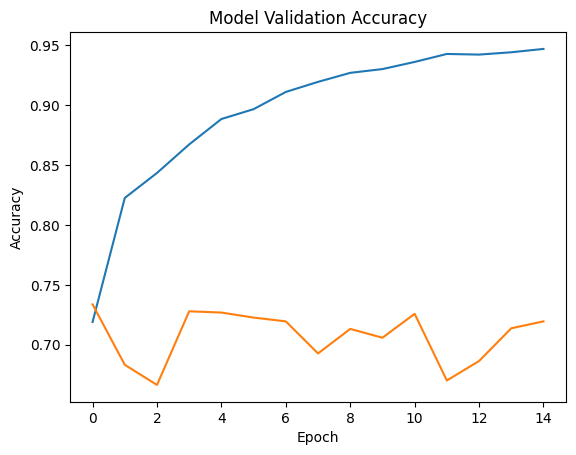

In [10]:
# Train the model
history = model.fit(train_padded_sequences, train_df['target'], validation_split=0.25, epochs=15, batch_size=16)

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = history.history['val_accuracy'][best_epoch - 1]

# Print the epoch and corresponding validation accuracy
print(f"Best epoch: {best_epoch}")
print(f"Validation accuracy at best epoch: {best_val_accuracy:.4f}")

# Plot the validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


Finally we fit the model to the test dataset and write a submission file.

In [11]:
# Train the final model
model.fit(train_padded_sequences, train_df['target'], epochs=best_epoch, batch_size=16)

# Apply the model to the test dataset
predictions = model.predict(test_padded_sequences)

# the predictions will likely be in the form of probabilities, so you may want to round them to binary values
binary_predictions = np.round(predictions)

# add the predictions to the 'test_df' dataframe
test_df['target'] = binary_predictions
test_df = test_df[['id', 'target']]
test_df['target'] = test_df['target'].astype(int)

# Save to CSV
test_df.to_csv('test_submission.csv', index=False)

102/102 [==============================] - 1s 4ms/step


<ipython-input-11-4b9368de3dbd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'] = test_df['target'].astype(int)


# Conclusions

I am satisfied with the results. We are getting about 75-78% accuracy when submitting to Kaggle.

I did end up adding a line to remove all characters that are not either a letter or a space from the original corpus. This did not seem to do much for us in terms of accuracy.

We do see that the tuner sems to like adding at least one dropout when looking to maximize validation accuracy, which sounds reasonable as we are trying to get to a model that is generalizable.

Overall I believe that maybe training our own embadding layer might not be the best idea with this small dataset. 7 thousand tweets seem to me to be just not enough to capture all the meaning in our tokens.

This is probably why most top-scoring attempts do use pre-trained layers like BERT. I do think, however, that since the scope of this assignment was to implement RNN and not necessarily go fot the best possible model, we have achieved a good simple enough implementation with reasonable results.